# import libraries

In [1]:
import os
import warnings
import itertools
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib as mpl
import numpy as np
import pandas as pd
from scipy import signal
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant

warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)


# define functions

In [2]:
def time_embed(df, lag):
    lagged_df = df.copy()[lag:].reset_index(drop=True)
    for l in range(1, lag+1):
        lagged_df = pd.merge(lagged_df, df[lag-l:-l].reset_index(drop=True), left_index=True, right_index=True,suffixes=("", "_Lag:{}".format(l)))
    return lagged_df


# initialize variables

In [3]:
training_data_folder = "Data"
training_user_folders = [f for f in os.listdir(training_data_folder) if os.path.isdir(os.path.join(training_data_folder, f))] # Get list of all user folders for trining
oos_data_folder = "Out-of-sample"
oos_user_folders = [f for f in os.listdir(oos_data_folder) if os.path.isdir(os.path.join(oos_data_folder, f))] # Get list of all user folders for oos
dfs = [] # Create an empty list to store DataFrames for all user
lag = 9 # there are 10 measurements per second
window_size = 15
K = 0.8 # fraction of data for training (1-K will be used for cross validation)


# feature extraction

In [4]:
# Iterate over each user folder
for user_id, user_folder in enumerate(training_user_folders, start=0):
    user_data_folder = os.path.join(training_data_folder, user_folder)
    print( "user "+str(user_id))
    print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'].str.strip(), format='%I:%M:%S.%f %p')
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    if user_data_folder[5:len(user_data_folder)] not in ['User-1','User-2','User-6',
                                                         'User-8','User-10','User-14',
                                                         'User-18','User-22','User-23']:
        df_imu.columns = ['Time', 'Roll2', 'Pitch2', 'Yaw2', 
                          'AccX2', 'AccY2', 'AccZ2', 
                          'RotX2','RotY2', 'RotZ2', 
                          'Roll1', 'Pitch1', 'Yaw1', 
                          'AccX1', 'AccY1', 'AccZ1',
                          'RotX1', 'RotY1', 'RotZ1']

    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()

    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

#     # Number of raw observsations in each dataset
#     print("falcon observations = "+str(np.shape(df_falcon)[0]))
#     print("imu observations = "+str(np.shape(df_imu)[0]))
    
    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    

    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(2,len(df_falcon)-2):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+2]-df_falcon[" falcon_x"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+2]-df_falcon[" falcon_y"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+2]-df_falcon[" falcon_z"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(2,len(df_imu)-2):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+2]-df_imu["AccX1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+2]-df_imu["AccY1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+2]-df_imu["AccZ1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arcsin"] = np.arcsin(((-0.1*df_imu["RotY1"]*df_imu["sin(Pitch1)"]+df_falcon["falcon_x_dot"]-df_imu["VelX1"])/0.1).apply(math.radians))
    df_imu["arccos"] = np.arccos(((0.1*df_imu["RotY1"]*df_imu["cos(Pitch1)"]-df_falcon["falcon_y_dot"]+df_imu["VelY1"])/0.1).apply(math.radians))


    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arcsin"] = signal.medfilt(df_imu["arcsin"],kernel_size=window_size)
    df_imu["arccos"] = signal.medfilt(df_imu["arccos"],kernel_size=window_size)

    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
features = pd.concat(dfs)

# remove irrelevant columns
features.drop(list(features.filter(regex='index')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
features.drop(list(features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)

# Save merged data to a new CSV file
features.to_csv('features.csv')


user 0
Data/User-11


/Users/ronibarakventura/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


user 1
Data/User-16
user 2
Data/User-3
user 3
Data/User-18
user 4
Data/User-5


/Users/ronibarakventura/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


user 5
Data/User-21
user 6
Data/User-2


/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:92: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+2]-df_falcon[" falcon_x"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:93: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+2]-df_falcon[" falcon_y"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:94: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+2]-df_falcon[" falcon_z"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()


user 7
Data/User-10


/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:92: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+2]-df_falcon[" falcon_x"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:93: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+2]-df_falcon[" falcon_y"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:94: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+2]-df_falcon[" falcon_z"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()


user 8
Data/User-15


/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:92: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+2]-df_falcon[" falcon_x"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:93: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+2]-df_falcon[" falcon_y"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1590764467.py:94: RuntimeWarning: invalid value encountered in double_scalars
  df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+2]-df_falcon[" falcon_z"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()


user 9
Data/User-9
user 10
Data/User-12
user 11
Data/User-24
user 12
Data/User-23
user 13
Data/User-0


/Users/ronibarakventura/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


user 14
Data/User-1
user 15
Data/User-6
user 16
Data/User-14
user 17
Data/User-8


# Test for autoregression and find optimal lag

lag 0
lag 1
lag 2
lag 3
lag 4
lag 5
lag 6
lag 7
lag 8
lag 9


/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/3711230204.py:52: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('results1.pdf', tightlayout=True)


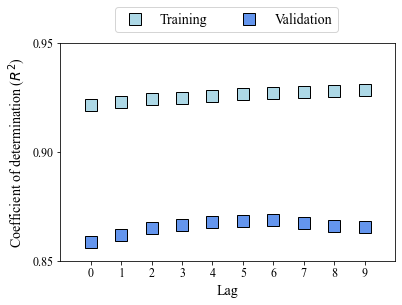

optimal lag: 6


In [6]:
# define variables for cross-validations
num_vars = np.shape(df_falcon.drop(list(df_falcon.filter(regex='index')), axis=1))[1] + np.shape(df_imu.drop(list(df_imu.filter(regex='index')), axis=1))[1]
gof_cross_validation = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for calculating mean squared error
gof_training = pd.DataFrame(columns=["lag","r-sq","mse"]) # empty array for calculating mean squared error

# define the input and output of the machine learning algorithm with no autoregressive terms
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

for l in np.arange(lag+1):
    print("lag "+str(l))
    
    # get only columns up to lag l
    x = X.iloc[:,list(range(0, num_vars*(l+1)))]

    # define training and validation data sets
    X_train = pd.DataFrame(columns=x.keys())
    X_test = pd.DataFrame(columns=x.keys())
    Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
    for id in np.unique(features["User"]):
        X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
        X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
        Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
        Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])
        
    # Train linear regression model for pitch
    model = LinearRegression()
    model.fit(X_train,Y_train[["Pitch"]])
    predictions = model.predict(X_test) 
    
    # Compute R-squared and MSE for cross validation
    gof_cross_validation.loc[len(gof_cross_validation)] = [l, r2_score(Y_test[["Pitch"]], predictions), mean_squared_error(Y_test[["Pitch"]], predictions)]
    
    # Compute R-squared and MSE for training
    predictions = model.predict(X_train)
    gof_training.loc[len(gof_cross_validation)] = [l, r2_score(Y_train[["Pitch"]], predictions), mean_squared_error(Y_train[["Pitch"]], predictions)]

# identify the optimal lag
x = np.arange(lag+1)
y1 = gof_training['r-sq']
y2 = gof_cross_validation['r-sq']
plt.plot(x, y1, 'bs',markersize=12,markerfacecolor='lightblue',markeredgecolor='black')
plt.plot(x, y2, 'bs',markersize=12,markerfacecolor='cornflowerblue',markeredgecolor='black')
plt.ylabel(r'Coefficient of determination ($R^2$)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Lag', fontsize=14, fontname='Times New Roman')
plt.xticks(np.arange(0,10), fontsize=12, fontname='Times New Roman')
plt.yticks([0.85, 0.9, 0.95, 1], fontsize=12, fontname='Times New Roman')
plt.xlim([-1, lag+1])
plt.ylim([0.85, 0.95])
plt.legend(['Training','Validation'],bbox_to_anchor=(0.85, 1.2), ncol=2, prop={'family':'Times New Roman', 'size':14}) 
plt.savefig('results1.pdf', tightlayout=True)
plt.show()

opt_lag = int(gof_cross_validation[gof_cross_validation["r-sq"]==max(gof_cross_validation["r-sq"])]["lag"])
print("optimal lag: "+str(opt_lag))


# Apply a linear regression model with optimal lag

/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/2249744859.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('results2.pdf', tightlayout=True)


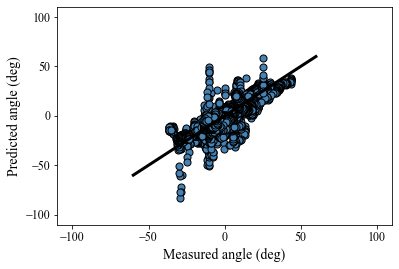

Testing R-squared: 0.8686133114857029
Testing MSE: 27.536100891554383


In [12]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns up to optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

# Train linear regression model
model = LinearRegression()
model.fit(X_train, Y_train[["Pitch"]])
predictions = model.predict(X_test)

# Scatter plot predictions vs. actual angles
plt.scatter(Y_test[["Pitch"]], predictions, edgecolors='k',c='steelblue',s=50)
plt.plot([-60, 60], [-60, 60], color='black', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.yticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.ylim([-110, 110])
plt.xlim([-110, 110])
plt.savefig('results2.pdf', tightlayout=True)
plt.show()


# Goodness-of-fit in cross-validation
r_squared = r2_score(Y_test[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y_test[["Pitch"]], predictions)
print("Testing MSE:", mse)

# # Goodness-of-fit in training
# predictions = model.predict(X_train)
# r_squared = r2_score(Y_train[["Pitch"]], predictions) # Compute R-squared
# print("Training R-squared:", r_squared)
# mse = mean_squared_error(Y_train[["Pitch"]], predictions) # Compute MSE
# print("Training MSE:", mse)


# Perform out-of-sample analysis

#### Compute features for out-of-sampe users

In [8]:
# Iterate over each user folder
for user_id, user_folder in enumerate(oos_user_folders, start=0):
    user_data_folder = os.path.join(oos_data_folder, user_folder)
    print("user "+str(user_id))
    print(user_data_folder)

    # Load CSV files for each user
    df_falcon = pd.read_csv(os.path.join(user_data_folder, "novint-falcon.csv"))
    df_falcon = df_falcon.rename(columns={'global time': 'Time'}) # rename time column for consistency
    df_imu = pd.read_csv(os.path.join(user_data_folder, "imu.csv"))
    df_angles = pd.read_csv(os.path.join(user_data_folder, "wrist-angles.csv"))
    
    # Convert time columns to datetime format
    df_falcon['Time'] = pd.to_datetime(df_falcon['Time'].str.strip(), format='%H:%M:%S.%f')
    df_imu['Time'] = pd.to_datetime(df_imu['Time'].str.strip(), format='%I:%M:%S.%f %p')
    df_angles['Time'] = pd.to_datetime(df_angles['Time'].str.strip(), format='%I:%M:%S.%f %p')

    if user_data_folder[5:len(user_data_folder)] not in ['User-1','User-2','User-6',
                                                         'User-8','User-10','User-14',
                                                         'User-18','User-22','User-23']:
        df_imu.columns = ['Time', 'Roll2', 'Pitch2', 'Yaw2', 
                          'AccX2', 'AccY2', 'AccZ2', 
                          'RotX2','RotY2', 'RotZ2', 
                          'Roll1', 'Pitch1', 'Yaw1', 
                          'AccX1', 'AccY1', 'AccZ1',
                          'RotX1', 'RotY1', 'RotZ1']

    df_img = pd.read_csv(os.path.join(user_data_folder, "IMG_2 (Instance).csv"))

    # Extract the time from the first row of df_img
    start_time_img = df_img.iloc[0][' time (s)']

    # Find the index of the exact time in df_falcon
    exact_index_falcon = df_falcon[df_falcon[' time (s)'] == start_time_img].index[0]

    # Slice df_falcon from the exact index
    df_falcon = df_falcon.iloc[exact_index_falcon:].reset_index(drop=True)

    # Calculate the time difference for df_angles and df_imu
    time_diff_angles = abs(df_angles['Time'] - df_falcon.iloc[0]['Time'])
    time_diff_imu = abs(df_imu['Time'] - df_falcon.iloc[0]['Time'])

    # Find the index of the minimum time difference
    nearest_index_angles = time_diff_angles.idxmin()
    nearest_index_imu = time_diff_imu.idxmin()

    # Slice df_angles and df_imu from the nearest index
    df_angles = df_angles.iloc[nearest_index_angles:].reset_index()
    df_imu = df_imu.iloc[nearest_index_imu:].reset_index()

    # Subset only columns relevant for training
    df_falcon = df_falcon.drop([' time (s)',' rotation_x',' rotation_y'], axis=1)
    df_imu.drop(list(df_imu.filter(regex='2')), axis=1, inplace=True) # remove anything with IMU2 that is placed on the back of the hand

    # Downsample the falcon data
    df_falcon_downsampled = pd.DataFrame(columns=df_falcon.keys())
    for ts in np.arange(len(df_angles)):
        min_index = abs(df_angles.iloc[ts]['Time'] - df_falcon['Time']).idxmin()
        df_falcon_downsampled.loc[len(df_falcon_downsampled.index)] = df_falcon.iloc[min_index-2:min_index+3][[' falcon_x',' falcon_y',' falcon_z']].mean()
    df_falcon = pd.concat([df_angles['Time'],df_falcon_downsampled.drop('Time', axis=1).reset_index(drop=True)], axis=1)

    # remove drift from IMU1 yaw
    m,b = np.polyfit(np.arange(np.shape(df_imu)[0]), df_imu["Yaw1"], 1)
    df_imu["Yaw1"] = df_imu["Yaw1"]-(m*np.arange(np.shape(df_imu)[0])+b)    

    # apply a median filter on all raw data
    df_angles["Roll"] = signal.medfilt(df_angles["Roll"],kernel_size=window_size)
    df_angles["Pitch"] = signal.medfilt(df_angles["Pitch"],kernel_size=window_size)
    df_angles["Yaw"] = signal.medfilt(df_angles["Yaw"],kernel_size=window_size)
    df_falcon[" falcon_x"] = signal.medfilt(df_falcon[" falcon_x"],kernel_size=window_size)
    df_falcon[" falcon_y"] = signal.medfilt(df_falcon[" falcon_y"],kernel_size=window_size)
    df_falcon[" falcon_z"] = signal.medfilt(df_falcon[" falcon_z"],kernel_size=window_size)
    df_imu["Yaw1"] = signal.medfilt(df_imu["Yaw1"],kernel_size=window_size)
    df_imu["Pitch1"] = signal.medfilt(df_imu["Pitch1"],kernel_size=window_size)
    df_imu["Roll1"] = signal.medfilt(df_imu["Roll1"],kernel_size=window_size)
    df_imu["AccX1"] = signal.medfilt(df_imu["AccX1"],kernel_size=window_size)
    df_imu["AccY1"] = signal.medfilt(df_imu["AccY1"],kernel_size=window_size)
    df_imu["AccZ1"] = signal.medfilt(df_imu["AccZ1"],kernel_size=window_size)
    df_imu["RotX1"] = signal.medfilt(df_imu["RotX1"],kernel_size=window_size)
    df_imu["RotY1"] = signal.medfilt(df_imu["RotY1"],kernel_size=window_size)
    df_imu["RotZ1"] = signal.medfilt(df_imu["RotZ1"],kernel_size=window_size)

    # add time derivatives in falcon data
    df_falcon["falcon_x_dot"] = df_falcon[" falcon_x"]
    df_falcon["falcon_y_dot"] = df_falcon[" falcon_y"]
    df_falcon["falcon_z_dot"] = df_falcon[" falcon_z"]
    for ts in np.arange(2,len(df_falcon)-2):
        df_falcon.loc[ts, 'falcon_x_dot'] = (df_falcon[" falcon_x"].loc[ts+2]-df_falcon[" falcon_x"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
        df_falcon.loc[ts, 'falcon_y_dot'] = (df_falcon[" falcon_y"].loc[ts+2]-df_falcon[" falcon_y"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()
        df_falcon.loc[ts, 'falcon_z_dot'] = (df_falcon[" falcon_z"].loc[ts+2]-df_falcon[" falcon_z"].loc[ts-2])/(df_falcon["Time"].loc[ts+2]-df_falcon["Time"].loc[ts-2]).total_seconds()

    # add time integrals in IMU data
    df_imu["VelX1"] = df_imu["AccX1"]
    df_imu["VelY1"] = df_imu["AccY1"]
    df_imu["VelZ1"] = df_imu["AccZ1"]    
    for ts in np.arange(2,len(df_imu)-2):
        df_imu.loc[ts,'VelX1'] = (df_imu["AccX1"].loc[ts+2]-df_imu["AccX1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()
        df_imu.loc[ts,'VelY1'] = (df_imu["AccY1"].loc[ts+2]-df_imu["AccY1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()
        df_imu.loc[ts,'VelZ1'] = (df_imu["AccZ1"].loc[ts+2]-df_imu["AccZ1"].loc[ts-2])*(df_imu["Time"].loc[ts+2]-df_imu["Time"].loc[ts-2]).total_seconds()

    # add features from the kinematic model
    df_imu["sin(Pitch1)"] = np.sin(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["sin(Yaw1)"] = np.sin(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["sin(Roll1)"] = np.sin(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["cos(Pitch1)"] = np.cos(df_imu["Pitch1"].astype(float).apply(math.radians))
    df_imu["cos(Yaw1)"] = np.cos(df_imu["Yaw1"].astype(float).apply(math.radians))
    df_imu["cos(Roll1)"] = np.cos(df_imu["Roll1"].astype(float).apply(math.radians))
    df_imu["RotX1*sin(Pitch1)"] = df_imu["RotX1"]*df_imu["sin(Pitch1)"]
    df_imu["RotY1*sin(Pitch1)"] = df_imu["RotY1"]*df_imu["sin(Pitch1)"]
    df_imu["RotZ1*sin(Pitch1)"] = df_imu["RotZ1"]*df_imu["sin(Pitch1)"]
    df_imu["RotX1*sin(Yaw1)"] = df_imu["RotX1"]*df_imu["sin(Yaw1)"]
    df_imu["RotY1*sin(Yaw1)"] = df_imu["RotY1"]*df_imu["sin(Yaw1)"]
    df_imu["RotZ1*sin(Yaw1)"] = df_imu["RotZ1"]*df_imu["sin(Yaw1)"]
    df_imu["RotX1*sin(Roll1)"] = df_imu["RotX1"]*df_imu["sin(Roll1)"]
    df_imu["RotY1*sin(Roll1)"] = df_imu["RotY1"]*df_imu["sin(Roll1)"]
    df_imu["RotZ1*sin(Roll1)"] = df_imu["RotZ1"]*df_imu["sin(Roll1)"]
    df_imu["RotX1*cos(Pitch1)"] = df_imu["RotX1"]*df_imu["cos(Pitch1)"]
    df_imu["RotY1*cos(Pitch1)"] = df_imu["RotY1"]*df_imu["cos(Pitch1)"]
    df_imu["RotZ1*cos(Pitch1)"] = df_imu["RotZ1"]*df_imu["cos(Pitch1)"]
    df_imu["RotX1*cos(Yaw1)"] = df_imu["RotX1"]*df_imu["cos(Yaw1)"]
    df_imu["RotY1*cos(Yaw1)"] = df_imu["RotY1"]*df_imu["cos(Yaw1)"]
    df_imu["RotZ1*cos(Yaw1)"] = df_imu["RotZ1"]*df_imu["cos(Yaw1)"]
    df_imu["RotX1*cos(Roll1)"] = df_imu["RotX1"]*df_imu["cos(Roll1)"]
    df_imu["RotY1*cos(Roll1)"] = df_imu["RotY1"]*df_imu["cos(Roll1)"]
    df_imu["RotZ1*cos(Roll1)"] = df_imu["RotZ1"]*df_imu["cos(Roll1)"]
    df_imu["arcsin"] = np.arcsin(((-0.1*df_imu["RotY1"]*df_imu["sin(Pitch1)"]+df_falcon["falcon_x_dot"]-df_imu["VelX1"])/0.1).apply(math.radians))
    df_imu["arccos"] = np.arccos(((0.1*df_imu["RotY1"]*df_imu["cos(Pitch1)"]-df_falcon["falcon_y_dot"]+df_imu["VelY1"])/0.1).apply(math.radians))


    # apply a median filter on computed values
    df_falcon["falcon_x_dot"] = signal.medfilt(df_falcon["falcon_x_dot"],kernel_size=window_size)
    df_falcon["falcon_y_dot"] = signal.medfilt(df_falcon["falcon_y_dot"],kernel_size=window_size)
    df_falcon["falcon_z_dot"] = signal.medfilt(df_falcon["falcon_z_dot"],kernel_size=window_size)
    df_imu["VelX1"] = signal.medfilt(df_imu["VelX1"],kernel_size=window_size)
    df_imu["VelY1"] = signal.medfilt(df_imu["VelY1"],kernel_size=window_size)
    df_imu["VelZ1"] = signal.medfilt(df_imu["VelZ1"],kernel_size=window_size)
    df_imu["sin(Pitch1)"] = signal.medfilt(df_imu["sin(Pitch1)"],kernel_size=window_size)
    df_imu["sin(Yaw1)"] = signal.medfilt(df_imu["sin(Yaw1)"],kernel_size=window_size)
    df_imu["sin(Roll1)"] = signal.medfilt(df_imu["sin(Roll1)"],kernel_size=window_size)
    df_imu["cos(Pitch1)"] = signal.medfilt(df_imu["cos(Pitch1)"],kernel_size=window_size)
    df_imu["cos(Yaw1)"] = signal.medfilt(df_imu["cos(Yaw1)"],kernel_size=window_size)
    df_imu["cos(Roll1)"] = signal.medfilt(df_imu["cos(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Pitch1)"] = signal.medfilt(df_imu["RotX1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Pitch1)"] = signal.medfilt(df_imu["RotY1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Pitch1)"] = signal.medfilt(df_imu["RotZ1*sin(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Yaw1)"] = signal.medfilt(df_imu["RotX1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Yaw1)"] = signal.medfilt(df_imu["RotY1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Yaw1)"] = signal.medfilt(df_imu["RotZ1*sin(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*sin(Roll1)"] = signal.medfilt(df_imu["RotX1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*sin(Roll1)"] = signal.medfilt(df_imu["RotY1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*sin(Roll1)"] = signal.medfilt(df_imu["RotZ1*sin(Roll1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Pitch1)"] = signal.medfilt(df_imu["RotX1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Pitch1)"] = signal.medfilt(df_imu["RotY1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Pitch1)"] = signal.medfilt(df_imu["RotZ1*cos(Pitch1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Yaw1)"] = signal.medfilt(df_imu["RotX1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Yaw1)"] = signal.medfilt(df_imu["RotY1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Yaw1)"] = signal.medfilt(df_imu["RotZ1*cos(Yaw1)"],kernel_size=window_size)
    df_imu["RotX1*cos(Roll1)"] = signal.medfilt(df_imu["RotX1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotY1*cos(Roll1)"] = signal.medfilt(df_imu["RotY1*cos(Roll1)"],kernel_size=window_size)
    df_imu["RotZ1*cos(Roll1)"] = signal.medfilt(df_imu["RotZ1*cos(Roll1)"],kernel_size=window_size)
    df_imu["arcsin"] = signal.medfilt(df_imu["arcsin"],kernel_size=window_size)
    df_imu["arccos"] = signal.medfilt(df_imu["arccos"],kernel_size=window_size)

    # change the time colmns to index to merge time series into a single dataframe
    df_angles = df_angles.set_index(['Time'])
    df_falcon = df_falcon.set_index(['Time'])
    df_imu = df_imu.set_index(['Time'])

    # Merge time series into a single dataframe
    df_data = pd.merge(df_angles, df_falcon, left_index=True, right_index=True)
    df_data = pd.merge(df_data, df_imu, left_index=True, right_index=True)

    # Revert index back to numerics
    df_data = df_data.reset_index(drop=True)
    
    # Lag the merged data
    df_data = time_embed(df_data, lag)

    # remove rows with NaN values
    df_data = df_data.dropna()

    # Add user ID column
    df_data['User'] = user_id

    # Append to the list of DataFrames
    dfs.append(df_data)

# Convert the dataframes into a pandas dataframe
oos_features = pd.concat(dfs)

# remove irrelevant columns
oos_features.drop(list(oos_features.filter(regex='index')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Roll_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Pitch_Lag:')), axis=1, inplace=True)
oos_features.drop(list(oos_features.filter(regex='Yaw_Lag:')), axis=1, inplace=True)

# Save merged data to a new CSV file
oos_features.to_csv('oos_features.csv')


user 0
Out-of-sample/User-7
user 1
Out-of-sample/User-22


#### Apply model on out-of-sample users

In [9]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = oos_features[["Pitch","Yaw","Roll"]]
X = oos_features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only columns within optimal lag
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))]

# Train linear regression model
predictions = model.predict(x)

# # Scatter plot predictions vs. actual angles
# plt.scatter(Y[["Pitch"]], predictions, edgecolors='k',c='darkorchid',s=50)
# plt.plot([-60, 60], [-60, 60], color='black', lw=3)
# plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
# plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
# plt.xticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
# plt.yticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
# plt.ylim([-110, 110])
# plt.xlim([-110, 110])
# plt.show()


# Goodness-of-fit
r_squared = r2_score(Y[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y[["Pitch"]], predictions)
print("Testing MSE:", mse)


Testing R-squared: 0.8541549030142215
Testing MSE: 34.495609144871686


# Quantify feature importance

/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/1251989579.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('results3.pdf', tightlayout=True)


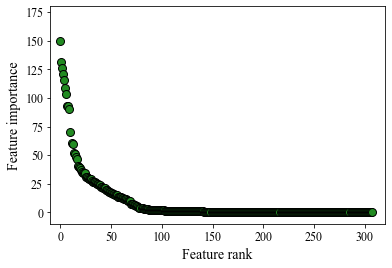

0      sin(Roll1)_Lag:6
1           VelZ1_Lag:6
2     sin(Pitch1)_Lag:6
3       cos(Yaw1)_Lag:4
4       cos(Yaw1)_Lag:6
5            sin(Roll1)
6           cos(Pitch1)
7           sin(Pitch1)
8                 VelY1
9           VelY1_Lag:6
10    cos(Pitch1)_Lag:6
11                VelX1
12           cos(Roll1)
13     cos(Roll1)_Lag:6
14                VelZ1
15      sin(Yaw1)_Lag:3
16    sin(Pitch1)_Lag:5
17      cos(Yaw1)_Lag:5
18    sin(Pitch1)_Lag:2
19    sin(Pitch1)_Lag:1
20          VelZ1_Lag:4
21          VelZ1_Lag:3
22     cos(Roll1)_Lag:1
23      sin(Yaw1)_Lag:2
24          VelX1_Lag:6
25          AccX1_Lag:6
26          VelZ1_Lag:1
27     sin(Roll1)_Lag:5
28    cos(Pitch1)_Lag:5
29     sin(Roll1)_Lag:1
30     sin(Roll1)_Lag:2
31     cos(Roll1)_Lag:4
32          VelY1_Lag:2
33          VelZ1_Lag:2
34    cos(Pitch1)_Lag:1
35    sin(Pitch1)_Lag:4
36                AccY1
37     sin(Roll1)_Lag:3
38          VelZ1_Lag:5
39            cos(Yaw1)
40          VelY1_Lag:1
41     sin(Roll1

In [10]:
# Get feature names
feature_names = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))].columns

# Get coefficients
coefficients = model.coef_[0,:]

# Create a dataframe for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute importance
feature_importance['Abs Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values('Abs Importance', ascending=False).reset_index()

# Display feature importance
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])
y = feature_importance['Abs Importance']
plt.plot(x, y, 'o',markersize=8,markerfacecolor='forestgreen',markeredgecolor='black')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 50, 100, 150, 200, 250, 300], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=12, fontname='Times New Roman')
plt.xlim([-10,320])
plt.ylim([-10,180])
plt.savefig('results3.pdf', tightlayout=True)
plt.show()

# Identify the most important features
contrib_to_importance = np.cumsum(feature_importance["Abs Importance"]/np.sum(feature_importance["Abs Importance"]))
fraction_contribution = 0.85
num_features = np.where(np.abs(contrib_to_importance-fraction_contribution)==np.min(np.abs(contrib_to_importance-fraction_contribution)))[0][0]
print(feature_importance[0:num_features]["Feature"])


# Show kinematic model parameters improve prediction

/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/3184198027.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('supp1.pdf', tightlayout=True)


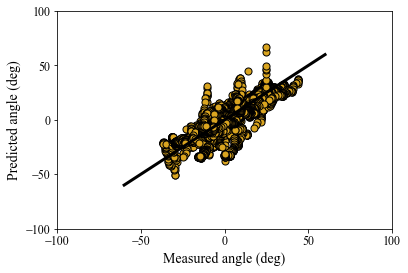

Testing R-squared: 0.8293372932119537
Testing MSE: 35.767592331319264
Training R-squared: 0.9091884796901998
Training MSE: 24.003069581289182


/var/folders/1z/stpw536n3499tbk7_sg5zch80000gn/T/ipykernel_28163/3184198027.py:74: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tightlayout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('supp2.pdf', tightlayout=True)


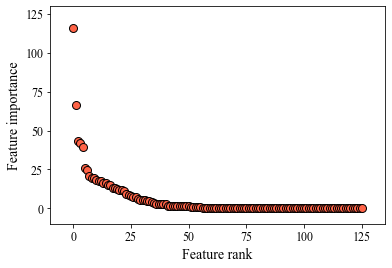

0           VelY1
1     VelZ1_Lag:6
2           VelZ1
3     VelZ1_Lag:4
4     AccX1_Lag:6
5     VelZ1_Lag:3
6     VelZ1_Lag:5
7           AccX1
8     AccX1_Lag:5
9     AccX1_Lag:1
10    AccX1_Lag:4
11    AccX1_Lag:3
12          VelX1
13    AccX1_Lag:2
14    VelY1_Lag:6
15    VelZ1_Lag:1
16    VelY1_Lag:3
17    VelY1_Lag:2
18    VelZ1_Lag:2
19          AccY1
20    VelY1_Lag:1
21    VelX1_Lag:2
22    VelX1_Lag:6
Name: Feature, dtype: object


In [11]:
# define the input and output of the machine learning algorithm with no autoregressive terms
Y = features[["Pitch","Yaw","Roll"]]
X = features.drop(["Pitch","Yaw","Roll"], axis=1)

# get only relevant
x = X.iloc[:,list(range(0, num_vars*(opt_lag+1)))] # columsn up to optimal lag
x.drop(list(x.filter(regex='sin')), axis=1, inplace=True) # columns that do not contain "sin" in their title
x.drop(list(x.filter(regex='cos')), axis=1, inplace=True) # columns that do not contain "cos" in their title

# define training and validation data sets
X_train = pd.DataFrame(columns=x.keys())
X_test = pd.DataFrame(columns=x.keys())
Y_train = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
Y_test = pd.DataFrame(columns=["Pitch","Yaw","Roll"])
for id in np.unique(features["User"]):
    X_train = pd.concat([X_train, x[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    X_test = pd.concat([X_test, x[features["User"]==id][round(K*len(features[features["User"]==id])):]])
    Y_train = pd.concat([Y_train, Y[features["User"]==id][:round(K*len(features[features["User"]==id]))]])
    Y_test = pd.concat([Y_test, Y[features["User"]==id][round(K*len(features[features["User"]==id])):]])

# Train linear regression model
model = LinearRegression()
model.fit(X_train, Y_train[["Pitch"]])
predictions = model.predict(X_test)

# Scatter plot predictions vs. actual angles
plt.scatter(Y_test[["Pitch"]], predictions, edgecolors='k',c='goldenrod',s=50)
plt.plot([-60, 60], [-60, 60], color='black', lw=3)
plt.ylabel('Predicted angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xlabel('Measured angle (deg)', fontsize=14, fontname='Times New Roman')
plt.xticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.yticks([-100, -50, 0, 50, 100], fontsize=12, fontname='Times New Roman')
plt.savefig('supp1.pdf', tightlayout=True)
plt.show()


# Goodness-of-fit in cross-validation
r_squared = r2_score(Y_test[["Pitch"]], predictions)
print("Testing R-squared:", r_squared)
mse = mean_squared_error(Y_test[["Pitch"]], predictions)
print("Testing MSE:", mse)

# Goodness-of-fit in training
predictions = model.predict(X_train)
r_squared = r2_score(Y_train[["Pitch"]], predictions) # Compute R-squared
print("Training R-squared:", r_squared)
mse = mean_squared_error(Y_train[["Pitch"]], predictions) # Compute MSE
print("Training MSE:", mse)


# Get feature names
feature_names = x.columns

# Get coefficients
coefficients = model.coef_[0,:]

# Create a dataframe for feature importance
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort by absolute importance
feature_importance['Abs Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values('Abs Importance', ascending=False).reset_index()

# Display feature importance
x = np.arange(np.shape(feature_importance['Abs Importance'])[0])
y = feature_importance['Abs Importance']
plt.plot(x, y, 'o',markersize=8,markerfacecolor='tomato',markeredgecolor='black')
plt.ylabel('Feature importance', fontsize=14, fontname='Times New Roman')
plt.xlabel('Feature rank', fontsize=14, fontname='Times New Roman')
plt.xticks([0, 25, 50, 75, 100, 125, 150, 175], fontsize=12, fontname='Times New Roman')
plt.yticks([0, 25, 50, 75, 100, 125], fontsize=12, fontname='Times New Roman')
plt.ylim([-10,130])
plt.xlim([-10,135])
plt.savefig('supp2.pdf', tightlayout=True)
plt.show()

# Identify the most important features
contrib_to_importance = np.cumsum(feature_importance["Abs Importance"]/np.sum(feature_importance["Abs Importance"]))
fraction_contribution = 0.85
num_features = np.where(np.abs(contrib_to_importance-fraction_contribution)==np.min(np.abs(contrib_to_importance-fraction_contribution)))[0][0]
print(feature_importance[0:num_features]["Feature"])

